# Importing packages and reading data

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly.express as px
from plotly.offline import iplot

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix
from sklearn.preprocessing import OneHotEncoder 
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

import spacy 

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,BatchNormalization,LSTM,GRU,Bidirectional,Embedding,SpatialDropout1D
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam,Adamax

from itertools import combinations
from collections import Counter
import regex as re
import random

2024-07-20 07:38:57.856646: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-20 07:38:57.856775: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-20 07:38:57.992757: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
df = pd.read_csv("/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv",names=["tweet_id","topic","sentiment","tweet"])

In [3]:
df_pred = pd.read_csv("/kaggle/input/twitter-entity-sentiment-analysis/twitter_validation.csv",names=["tweet_id","topic","sentiment","tweet"])

In [4]:
df

,tweet_id,topic,sentiment,tweet
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
...,...,...,...,...
74677,9200,Nvidia,Positive,Just realized that the Windows partition of my...
74678,9200,Nvidia,Positive,Just realized that my Mac window partition is ...
74679,9200,Nvidia,Positive,Just realized the windows partition of my Mac ...
74680,9200,Nvidia,Positive,Just realized between the windows partition of...


In [5]:
df_pred

,tweet_id,topic,sentiment,tweet
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...
...,...,...,...,...
995,4891,GrandTheftAuto(GTA),Irrelevant,⭐️ Toronto is the arts and culture capital of ...
996,4359,CS-GO,Irrelevant,tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...
997,2652,Borderlands,Positive,Today sucked so it’s time to drink wine n play...
998,8069,Microsoft,Positive,Bought a fraction of Microsoft today. Small wins.


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet_id   74682 non-null  int64 
 1   topic      74682 non-null  object
 2   sentiment  74682 non-null  object
 3   tweet      73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [7]:
df_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet_id   1000 non-null   int64 
 1   topic      1000 non-null   object
 2   sentiment  1000 non-null   object
 3   tweet      1000 non-null   object
dtypes: int64(1), object(3)
memory usage: 31.4+ KB


# Data cleaning

## Removing NaNs and duplicated rows

In [8]:
df.isna().sum()

tweet_id       0
topic          0
sentiment      0
tweet        686
dtype: int64

In [9]:
df.duplicated().sum()

2700

In [10]:
df = df.dropna()
df = df.drop_duplicates()

## Dropping unnecessary columns

In [11]:
df_train = df.drop(columns="tweet_id")
df_pred = df_pred.drop(columns="tweet_id")

In [12]:
df

,tweet_id,topic,sentiment,tweet
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
...,...,...,...,...
74677,9200,Nvidia,Positive,Just realized that the Windows partition of my...
74678,9200,Nvidia,Positive,Just realized that my Mac window partition is ...
74679,9200,Nvidia,Positive,Just realized the windows partition of my Mac ...
74680,9200,Nvidia,Positive,Just realized between the windows partition of...


# EDA

In [13]:
print(df.sentiment.value_counts())
print("---------------------------------------")
print(df.topic.value_counts())

sentiment
Negative      21698
Positive      19713
Neutral       17708
Irrelevant    12537
Name: count, dtype: int64
---------------------------------------
topic
TomClancysRainbowSix                 2328
Verizon                              2319
MaddenNFL                            2315
CallOfDuty                           2314
Microsoft                            2304
WorldOfCraft                         2300
NBA2K                                2299
LeagueOfLegends                      2296
TomClancysGhostRecon                 2291
Facebook                             2289
ApexLegends                          2278
johnson&johnson                      2257
Battlefield                          2255
Amazon                               2249
CallOfDutyBlackopsColdWar            2242
FIFA                                 2238
Dota2                                2225
Overwatch                            2220
Hearthstone                          2219
HomeDepot                            221

In [14]:
print(df_pred.sentiment.value_counts())
print("---------------------------------------")
print(df_pred.topic.value_counts())

sentiment
Neutral       285
Positive      277
Negative      266
Irrelevant    172
Name: count, dtype: int64
---------------------------------------
topic
RedDeadRedemption(RDR)               40
johnson&johnson                      39
PlayerUnknownsBattlegrounds(PUBG)    38
FIFA                                 38
LeagueOfLegends                      37
ApexLegends                          36
Nvidia                               35
TomClancysRainbowSix                 35
GrandTheftAuto(GTA)                  35
Amazon                               34
Fortnite                             34
PlayStation5(PS5)                    33
AssassinsCreed                       33
Borderlands                          33
Facebook                             33
Verizon                              32
Hearthstone                          32
Overwatch                            32
CS-GO                                32
CallOfDuty                           31
WorldOfCraft                         30
Cyberp

In [15]:
sentiments = df.sentiment.value_counts().reset_index()
iplot(px.bar(data_frame=sentiments,x="sentiment",y="count",\
             color_discrete_sequence=px.colors.sequential.algae,title="Number of tweets of each sentiment",template="plotly_dark"))

In [16]:
creators = df.topic.value_counts().reset_index()
iplot(px.pie(data_frame=creators,names="topic",values="count",width=1250,height=800,\
             color_discrete_sequence=px.colors.cyclical.mrybm,title="Number of tweets by topic",template="plotly_dark"))

# Preprocessing the data

## Loading spacy dictionary and making preprocess function

In [17]:
nlp = spacy.load("en_core_web_sm") 

In [18]:
# use this utility function to get the preprocessed text data
def preprocess(text):
    # remove all special charecters
    text = re.sub(r"[^A-z,0-9,\s]","",text)
    # remove extra spaces
    text = re.sub(r"(\s)+",r" ",text)
    # remove whitespace
    text = text.strip()
    #lemmatizing and removing stop words and punctuation
    doc = nlp(text)
    filtered_tokens = [token.lemma_ for token in doc if not token.is_punct and not token.is_stop]
    
    return " ".join(filtered_tokens) 


In [19]:
df["text"] = df["tweet"].apply(preprocess)

## Top 10 most common words for each sentiment

In [20]:
def top_10_words(df):
    counter = Counter()
    for row in df.text:
        row_list = row.split(" ")
        counter.update(Counter(combinations(row_list,1)))
        
    words = pd.DataFrame(counter.keys())
    words["values"] = counter.values()
    words.rename(columns={0:"word"},inplace=True)
    words["values"]=words["values"].astype("int32")
    words["word"]=words["word"].astype(str)
    words=words.sort_values(by="values",ascending=False).reset_index(drop=True)

    return words[:10]

In [21]:
postive_words = top_10_words(df.query("sentiment == 'Positive'"))

iplot(px.bar(data_frame=postive_words,x=postive_words["word"],y=postive_words["values"],\
             title="Top 10 most common words for postive sentiment",\
             color_discrete_sequence=px.colors.sequential.Teal,template="plotly_dark"))

In [22]:
negative_words = top_10_words(df.query("sentiment == 'Negative'"))

iplot(px.bar(data_frame=negative_words,x=negative_words["word"],y=negative_words["values"],\
             title="Top 10 most common words for negative sentiment",\
             color_discrete_sequence=px.colors.sequential.Aggrnyl,template="plotly_dark"))

In [23]:
neutral_words = top_10_words(df.query("sentiment == 'Neutral'"))

iplot(px.bar(data_frame=neutral_words,x=neutral_words["word"],y=neutral_words["values"],\
             title="Top 10 most common words for neutral sentiment",\
             color_discrete_sequence=px.colors.sequential.amp,template="plotly_dark"))

In [24]:
irrelevant_words = top_10_words(df.query("sentiment == 'Irrelevant'"))

iplot(px.bar(data_frame=irrelevant_words,x=irrelevant_words["word"],y=irrelevant_words["values"],\
             title="Top 10 most common words for irrelevant sentiment",\
             color_discrete_sequence=px.colors.sequential.turbid,template="plotly_dark"))

## Encoding target using OneHotEncoder and splitting data into train,test and validation

In [25]:
x = df["text"]
y = pd.DataFrame(df["sentiment"])

In [26]:
encoder = OneHotEncoder(sparse_output=False)

In [27]:
encoded_column = encoder.fit_transform(y[["sentiment"]])

In [28]:
y = pd.DataFrame(encoded_column, columns=encoder.get_feature_names_out(["sentiment"]))

In [29]:
encoder.get_feature_names_out(["sentiment"])

array(['sentiment_Irrelevant', 'sentiment_Negative', 'sentiment_Neutral',
       'sentiment_Positive'], dtype=object)

In [30]:
y

,sentiment_Irrelevant,sentiment_Negative,sentiment_Neutral,sentiment_Positive
0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,1.0
...,...,...,...,...
71651,0.0,0.0,0.0,1.0
71652,0.0,0.0,0.0,1.0
71653,0.0,0.0,0.0,1.0
71654,0.0,0.0,0.0,1.0


In [31]:
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=42 ,shuffle = True,stratify=y)

In [32]:
X_test, X_val, y_test, y_val = train_test_split(X_test,y_test, test_size=0.50, random_state=42,shuffle = True, stratify=y_test)

## Tokenizing the data for LSTM input

In [33]:
tokenizer = Tokenizer(num_words=30_000)
tokenizer.fit_on_texts(df['text'])
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_val_seq = tokenizer.texts_to_sequences(X_val)

# Padding sequences

In [34]:
max_sequence_length = 100
X_train_padded = pad_sequences(X_train_seq, maxlen=max_sequence_length)
X_test_padded = pad_sequences(X_test_seq, maxlen=max_sequence_length)
X_val_padded = pad_sequences(X_val_seq, maxlen=max_sequence_length)

In [35]:
X_train_padded.shape

(57324, 100)

In [36]:
X_test_padded.shape

(7166, 100)

In [37]:
X_val_padded .shape

(7166, 100)

# Model Structure

In [38]:
embedding_dim = 150 
batch_size = 32
epochs = 30

In [39]:
model = Sequential([
    Embedding(input_dim=30_000, output_dim=embedding_dim),
    SpatialDropout1D(0.4),
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.4),
    Bidirectional(LSTM(128, return_sequences=False)),
    Dropout(0.4),
    Dense(64,activation="relu"),
    Dense(4,activation="softmax")
])

model.compile(optimizer= Adamax(learning_rate=0.001), loss= 'categorical_crossentropy' , metrics= ["accuracy"])


In [40]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │   0 (unbuilt) │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

# Training model and evaluating

In [41]:
history = model.fit(X_train_padded, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val_padded, y_val))

Epoch 1/30
1792/1792 ━━━━━━━━━━━━━━━━━━━━ 65s 31ms/step - accuracy: 0.4178 - loss: 1.2613 - val_accuracy: 0.5941 - val_loss: 0.9980
Epoch 2/30
1792/1792 ━━━━━━━━━━━━━━━━━━━━ 54s 30ms/step - accuracy: 0.6098 - loss: 0.9621 - val_accuracy: 0.6793 - val_loss: 0.8224
Epoch 3/30
1792/1792 ━━━━━━━━━━━━━━━━━━━━ 54s 30ms/step - accuracy: 0.6971 - loss: 0.7825 - val_accuracy: 0.7210 - val_loss: 0.7153
Epoch 4/30
1792/1792 ━━━━━━━━━━━━━━━━━━━━ 54s 30ms/step - accuracy: 0.7502 - loss: 0.6575 - val_accuracy: 0.7586 - val_loss: 0.6369
Epoch 5/30
1792/1792 ━━━━━━━━━━━━━━━━━━━━ 54s 30ms/step - accuracy: 0.7888 - loss: 0.5609 - val_accuracy: 0.7806 - val_loss: 0.5799
Epoch 6/30
1792/1792 ━━━━━━━━━━━━━━━━━━━━ 54s 30ms/step - accuracy: 0.8157 - loss: 0.4919 - val_accuracy: 0.7984 - val_loss: 0.5321
Epoch 7/30
1792/1792 ━━━━━━━━━━━━━━━━━━━━ 81s 29ms/step - accuracy: 0.8396 - loss: 0.4299 - val_accuracy: 0.8134 - val_loss: 0.4883
Epoch 8/30
1792/1792 ━━━━━━━━━━━━━━━━━━━━ 53s 29ms/step - accuracy: 0.8489 -

In [42]:
model.evaluate(X_test_padded,y_test)

224/224 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8863 - loss: 0.3824


[0.4059147238731384, 0.8818029761314392]

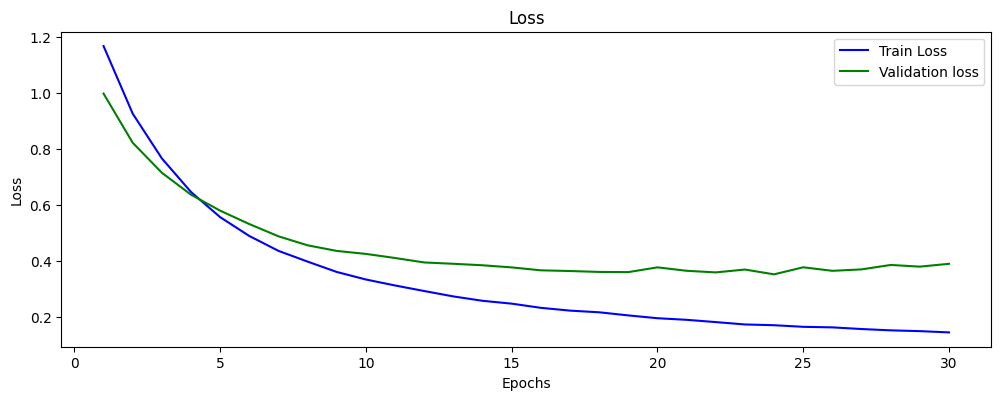

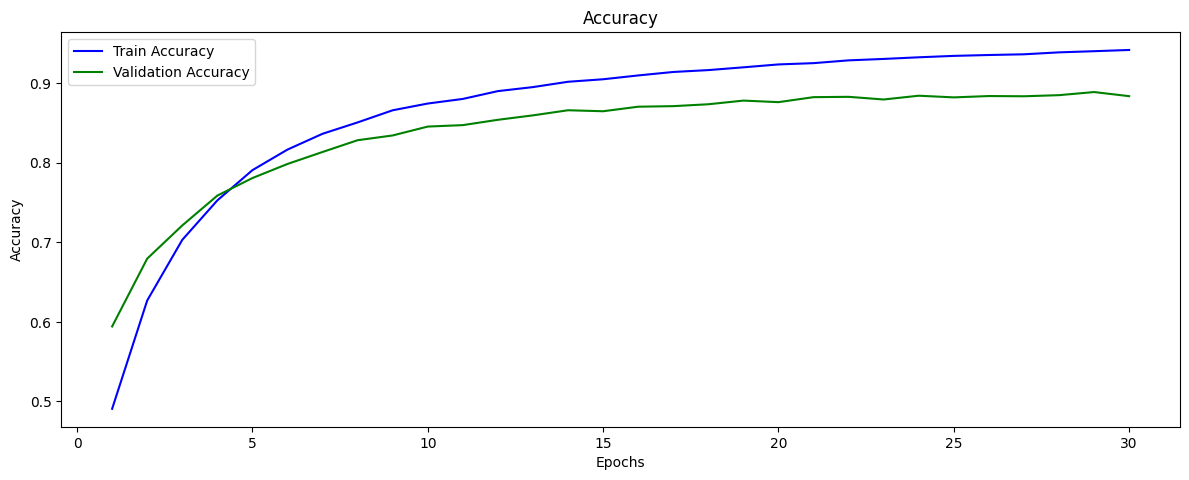

In [43]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = [i+1 for i in range(len(train_acc))]

plt.figure(figsize=(12,9))
plt.subplot(2,1,1)
plt.plot(epochs,train_loss,'b',label="Train Loss")
plt.plot(epochs,val_loss,'g',label="Validation loss")
plt.title("Loss")
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.figure(figsize=(12,9))
plt.subplot(2,1,1)
plt.plot(epochs,train_acc,'b',label="Train Accuracy")
plt.plot(epochs,val_acc,'g',label="Validation Accuracy")
plt.title("Accuracy")
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

In [44]:
 y_predicted = model.predict(X_test_padded)
y_predicted = (y_predicted>0.5)

print(classification_report(y_test,y_predicted,))

224/224 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step
              precision    recall  f1-score   support

           0       0.92      0.81      0.87      1253
           1       0.91      0.90      0.90      2170
           2       0.93      0.86      0.90      1771
           3       0.90      0.86      0.88      1972

   micro avg       0.91      0.86      0.89      7166
   macro avg       0.91      0.86      0.89      7166
weighted avg       0.91      0.86      0.89      7166
 samples avg       0.86      0.86      0.86      7166



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.



224/224 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


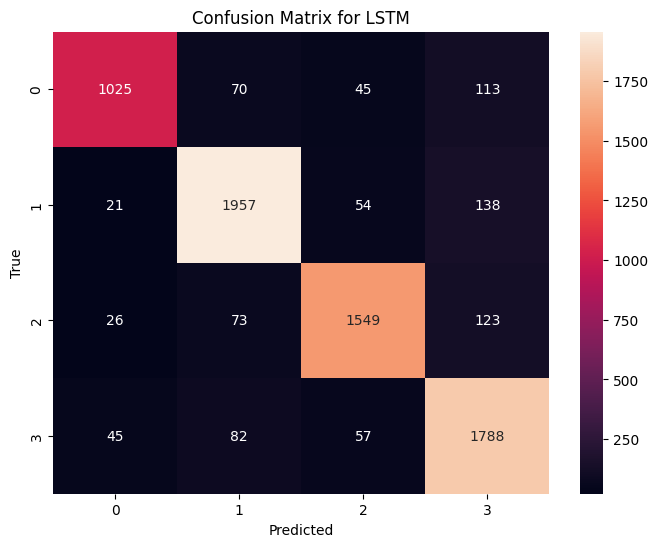

In [45]:
y_pred_probs = model.predict(X_test_padded)
y_pred_labels = np.argmax(y_pred_probs, axis=1)
y_true_labels = np.argmax(y_test, axis=1)
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for LSTM')
plt.show()

# Predicting random tweets from prediction data

In [46]:
def predict_tweet(text):
    
    cleaned_text = preprocess(text)
    
    # Tokenize and pad the text
    sequence = tokenizer.texts_to_sequences([text])
    padded_sequence = pad_sequences(sequence, maxlen=max_sequence_length)
    
    # Predict the label
    prediction = model.predict(padded_sequence,verbose=0)
    
    # Return the predicted label (0 o
    return np.argmax(prediction)

In [47]:
df_pred

,topic,sentiment,tweet
0,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,Google,Neutral,Now the President is slapping Americans in the...
...,...,...,...
995,GrandTheftAuto(GTA),Irrelevant,⭐️ Toronto is the arts and culture capital of ...
996,CS-GO,Irrelevant,tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...
997,Borderlands,Positive,Today sucked so it’s time to drink wine n play...
998,Microsoft,Positive,Bought a fraction of Microsoft today. Small wins.


In [48]:
map = {0:"Irrelevant",1:"Negative",2:"Neutral",3:"Positive"}
random_numbers = random.sample(range(0, 999 + 1), 30)
for n in random_numbers:
    pred = predict_tweet(df_pred.iloc[n,-1])
    print(f"The predicted sentiment for tweet '{df_pred.iloc[n,2]}' is {map[pred]} and the true sentiment is {df_pred.iloc[n,1]}\n")
    print("------------------------------------------------------------------------")    

The predicted sentiment for tweet 'what a joke #TomClancysRainbowSixSiege #XboxShare pic.twitter.com/flxOM0xVub' is Negative and the true sentiment is Negative

------------------------------------------------------------------------
The predicted sentiment for tweet 'It's Very Interesting If We Get Something For Smartphones By Nvidia' is Neutral and the true sentiment is Positive

------------------------------------------------------------------------
The predicted sentiment for tweet 'woops made a bunch of boomer men mad on facebook lmfaoooo pic.twitter.com/3yijBzv2Fs' is Neutral and the true sentiment is Neutral

------------------------------------------------------------------------
The predicted sentiment for tweet 'Fuck everyone who has got the RTX 3080 🖕🏻I haven’t even got a good enough pc to put one in @NVIDIAGeForce @nvidia' is Negative and the true sentiment is Negative

------------------------------------------------------------------------
The predicted sentiment for twe